In [1]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive
#@title Install requirements
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output
import base64
from IPython.display import display, HTML

Mounted at /content/drive


In [2]:
import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = "sk-vWY1pqcjPEKk6HKjbfly6vPiiEVurpt15dMvtIXLjIZ98bAk"
# STABILITY_KEY = getpass.getpass('API-KEY')

In [3]:
#@title Image Generation functions

def send_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        print(f"Polling results at https://api.stability.ai/v2beta/results/{generation_id}")
        response = requests.get(
            f"https://api.stability.ai/v2beta/results/{generation_id}",
            headers={
                **headers,
                "Accept": "*/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/ultra...
Saved image generated_327376662.jpeg


<IPython.core.display.Javascript object>

Result image:


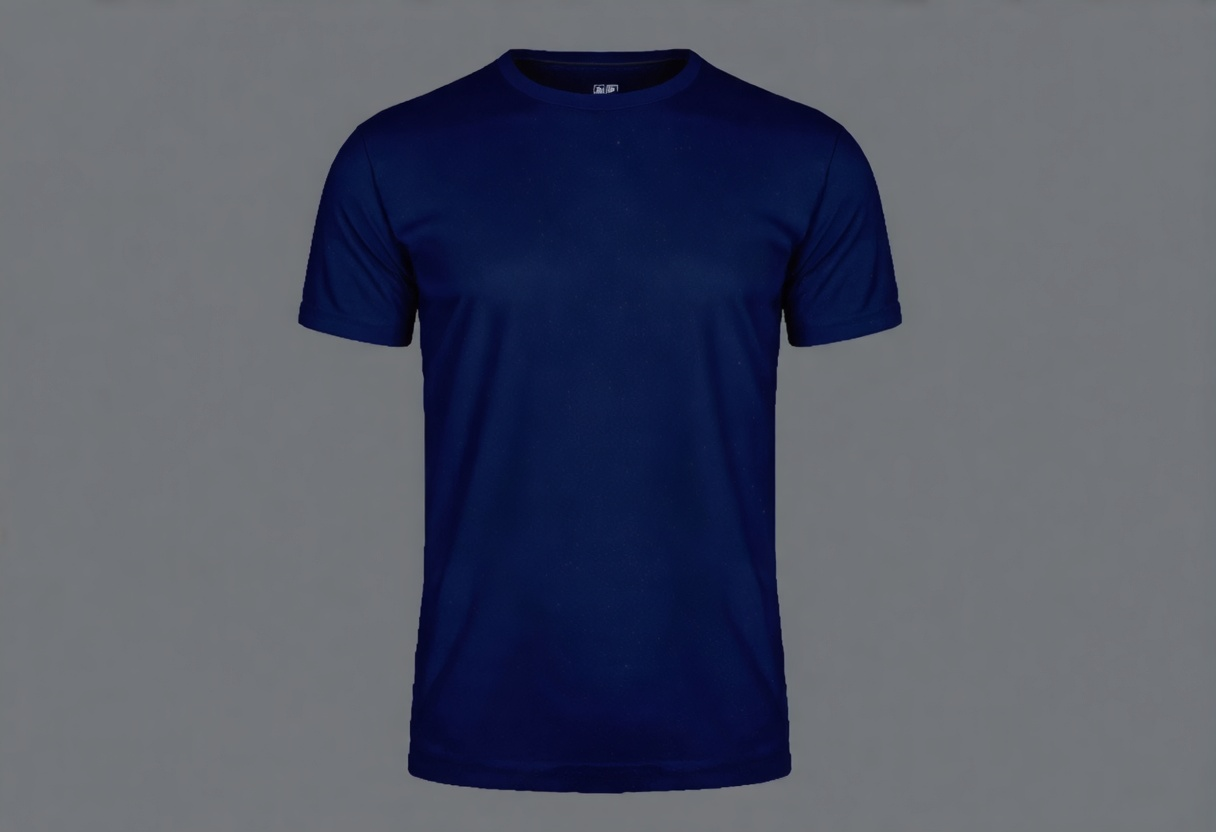

In [8]:
#@title Stable Image Ultra

prompt = "Dark Blue half sleeves T-Shirt outfit only 3D " #@param {type:"string"}
negative_prompt = "humun" #@param {type:"string"}
aspect_ratio = "3:2" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/generate/ultra"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "aspect_ratio" : aspect_ratio,
    "seed" : seed,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))


In [5]:
#@title Image-2-3D Utility functions definitions

def display_glb(file_path):
    with open(file_path, "rb") as file:
        glb_base64 = base64.b64encode(file.read()).decode('utf-8')

    html_content = f"""
    <html>
      <head>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/loaders/GLTFLoader.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/controls/OrbitControls.js"></script>
      </head>
      <body>
        <div id="container" style="width: 500px; height: 500px;"></div>
        <script>
          const scene = new THREE.Scene();
          const camera = new THREE.PerspectiveCamera(75, 1, 0.1, 1000);
          const renderer = new THREE.WebGLRenderer({{antialias: true}});
          renderer.setSize(500, 500);
          renderer.setClearColor(0x404040);
          document.getElementById('container').appendChild(renderer.domElement);

          const controls = new THREE.OrbitControls(camera, renderer.domElement);
          controls.enableDamping = true;
          controls.dampingFactor = 0.25;
          controls.enableZoom = true;

          const ambientLight = new THREE.AmbientLight(0xffffff, 0.5);
          scene.add(ambientLight);
          const directionalLight = new THREE.DirectionalLight(0xffffff, 0.6);
          directionalLight.position.set(0.5, 1, -1.5);
          scene.add(directionalLight);

          const loader = new THREE.GLTFLoader();
          const glbData = atob('{glb_base64}');
          const glbBuffer = new Uint8Array(glbData.length);
          for (let i = 0; i < glbData.length; i++) {{
            glbBuffer[i] = glbData.charCodeAt(i);
          }}

          loader.parse(glbBuffer.buffer, '', (gltf) => {{
            scene.add(gltf.scene);

            const box = new THREE.Box3().setFromObject(gltf.scene);
            const center = box.getCenter(new THREE.Vector3());
            const size = box.getSize(new THREE.Vector3());
            const maxDim = Math.max(size.x, size.y, size.z);

            const fov = camera.fov * (Math.PI / 180);
            let cameraZ = Math.abs(maxDim / 2 / Math.tan(fov / 2));
            camera.position.z = cameraZ * -1.5;
            camera.lookAt(center);

            controls.target.copy(center);
            controls.update();

            function animate() {{
              requestAnimationFrame(animate);
              controls.update();
              renderer.render(scene, camera);
            }}
            animate();
          }}, undefined, (error) => {{
            console.error('Error loading GLB:', error);
          }});
        </script>
      </body>
    </html>
    """
    display(HTML(html_content))

def image_to_3d(host, image_path, texture_resolution, foreground_ratio):
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers={"Authorization": f"Bearer {STABILITY_KEY}"},
        files={"image": open(image_path, 'rb')},
        data={
            "foreground_ratio" : foreground_ratio,
            "texture_resolution" : texture_resolution,
        }
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

Sending REST request to https://api.stability.ai/v2beta/3d/stable-fast-3d...
Saved 3D model model.glb


<IPython.core.display.Javascript object>

Original image:


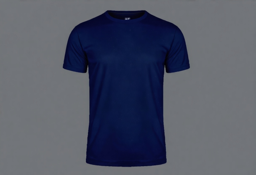

3D model result:


In [9]:
#@title Stable Fast 3D

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/generated_327376662.jpeg" #@param {type:"string"}
texture_resolution = "2048" #@param ['512', '1024', '2048'] {type:"string"}
foreground_ratio = 0.85 #@param {type:"number"}

host = "https://api.stability.ai/v2beta/3d/stable-fast-3d"

response = image_to_3d(
    host,
    image,
    texture_resolution,
    foreground_ratio
)

# Save the model
filename = f"model.glb"
with open(filename, "wb") as f:
    f.write(response.content)
print(f"Saved 3D model {filename}")

# Display the result
output.no_vertical_scroll()
print("Original image:")
thumb = Image.open(image)
thumb.thumbnail((256, 256))
display(thumb)
print("3D model result:")
display_glb(filename)
